In [1]:
import pandas as pd
import numpy as np
import glob
import os
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.cluster import AgglomerativeClustering
import matplotlib.font_manager as fm
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

CUSTOM_FONT_PATH     = "/content/drive/MyDrive/lmroman10-regular.otf" #r"lmroman10-regular.otf"
CUSTOM_FONT_NAME     = "Latin Modern Roman"

if CUSTOM_FONT_PATH:
    fm.fontManager.addfont(CUSTOM_FONT_PATH)
    plt.rcParams['font.family'] = CUSTOM_FONT_NAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set path to your CSV files
csv_dir = "/content/drive/MyDrive/8K60FPS_Link/30sec/Analysis/video_complixity/*.csv"  # 8K60FPS_Link is a shortcut folder to the VEDIA dataset

# Get sorted list of CSV files
all_files = sorted(glob.glob(csv_dir))

# Initialize list to store DataFrames
dfs = []

for file in all_files:
    try:
        if 'vmaf' in file:
            continue
        # Extract video number from filename (assuming format: 000_videoname.csv)
        filename = os.path.basename(file)
        video_number = int(filename.split('_')[0])  # First part is numeric

        # Read CSV and add video number column
        df = pd.read_csv(file)
        df['video_number'] = video_number
        df['video_id'] = f"{video_number:03d}_10s"


        dfs.append(df)

    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Optional: Verify results
print(f"Combined DataFrame shape: {combined_df.shape}")
print("Number of unique videos:", len(combined_df['video_number'].unique()))

Combined DataFrame shape: (70200, 22)
Number of unique videos: 39


In [4]:
# viewing loaded data
combined_df.head(10)

,Frame,SI,TI,Contrast,Sharpness,Blockiness,TextureComplexity,ColorVar_U,ColorVar_V,Colorfulness,...,Entropy,EntropyDiff,MotionIntensityDiff,EdgeDirectionality,AvgMotionXAxis,AvgMotionYAxis,StdMotionXAxis,StdMotionYAxis,video_number,video_id
0,0,67.4055,0.0000,220.875,295.00,81.6250,0.2221,1723.0,1386.0,70.6250,...,7.1115,0.0000,0.0000,4.1565,0.0000,0.0000,0.0000,0.0000,0,000_10s
1,1,67.4284,5.6328,220.875,295.25,81.6875,0.2221,1723.0,1386.0,70.6250,...,7.1114,0.0001,4.1133,4.1564,0.0436,0.0834,0.2129,0.2294,0,000_10s
2,2,67.4326,6.2891,220.875,295.25,81.6875,0.2220,1723.0,1386.0,70.6250,...,7.1108,0.0005,4.2500,4.1565,0.0135,0.0484,0.2133,0.1982,0,000_10s
3,3,67.4462,8.3516,221.000,295.50,81.7500,0.2221,1723.0,1383.0,70.6250,...,7.1102,0.0007,4.6953,4.1565,0.0501,-0.1421,0.4829,1.1719,0,000_10s
4,4,67.5036,9.9375,221.250,295.75,81.8750,0.2219,1723.0,1380.0,70.6250,...,7.1092,0.0009,5.0195,4.1565,-0.0496,-0.3489,0.9673,1.7539,0,000_10s
5,5,67.5152,11.2734,221.375,296.00,81.8750,0.2219,1722.0,1377.0,70.5625,...,7.1081,0.0012,5.2656,4.1565,0.0164,-0.0486,0.8174,1.0654,0,000_10s
6,6,67.4967,11.7578,221.500,295.75,82.0000,0.2218,1722.0,1376.0,70.5625,...,7.1066,0.0015,5.4219,4.1565,-0.1440,-0.2651,1.4385,1.5557,0,000_10s
7,7,67.4592,11.1875,221.500,295.50,82.0000,0.2217,1721.0,1377.0,70.5625,...,7.1054,0.0012,5.3945,4.1565,-0.3015,-0.1072,1.2744,1.0791,0,000_10s
8,8,67.3959,10.3203,221.625,295.00,81.9375,0.2217,1721.0,1377.0,70.5625,...,7.1046,0.0008,5.2812,4.1565,-0.2272,-0.1047,1.2031,0.7432,0,000_10s
9,9,67.3197,9.9766,221.625,294.50,82.0000,0.2219,1720.0,1380.0,70.5625,...,7.1045,0.0001,5.2070,4.1565,-0.3467,-0.1203,1.1201,0.5996,0,000_10s


In [5]:
# Custom aggregation functions
def linear_trend(s):
    x = np.arange(len(s))
    return np.polyfit(x, s, 1)[0] if len(s) > 1 else np.nan

def entropy(s):
    return skew(s) * kurtosis(s)  # Custom complexity measure

# Define the columns you want to keep

columns_to_use = [
 'SI',
 'TI',
 'TextureComplexity',
 'Colorfulness',
 'Entropy',
 'AvgMotionXAxis',
 'AvgMotionYAxis',
 'video_number'
]

# Filter the DataFrame
filtered_df = combined_df[columns_to_use].copy()

# Confirm 'video_number' is present
assert 'video_number' in filtered_df.columns

# Define numeric columns (excluding 'video_number')
numeric_cols = filtered_df.select_dtypes(include=np.number).columns.difference(['video_number']).tolist()


# Define comprehensive aggregations
def safe_skew(x):
    if len(x) < 3 or x.std() < 1e-8:
        return np.nan
    return skew(x, bias=False)

def safe_kurtosis(x):
    if len(x) < 4 or x.std() < 1e-8:
        return np.nan
    return kurtosis(x, bias=False)

def stabilized_entropy(x):
    hist = np.histogram(x, bins='auto')[0].astype(float)
    hist += 1e-12  # Prevent zero probabilities
    hist /= hist.sum()
    return -np.sum(hist * np.log(hist))

def safe_hurst(x):
    if len(x) < 10 or np.std(x) < 1e-8:
        return np.nan
    return np.log(np.std(x) + 1e-12) / np.log(len(x))

def robust_autocorr(x):
    if len(x) < 2 or x.std() < 1e-8:
        return np.nan
    return x.autocorr(lag=1)

# Create the aggregation dictionary
agg_config = {
    col: [
        ('mean', lambda x: np.nanmean(x)),
        ('std', lambda x: np.nanstd(x)),
        ('range', lambda x: np.nanmax(x) - np.nanmin(x)),
        ('skew', safe_skew),
        ('kurt', safe_kurtosis),
        ('median', lambda x: np.nanmedian(x)),
        ('mad', lambda x: np.nanmean(np.abs(x - np.nanmean(x)))),
        ('trend', linear_trend),
        ('autocorr', robust_autocorr),
        ('fft1', lambda x: np.abs(np.fft.fft(x.fillna(0).values)[1]) if len(x) > 1 else np.nan),
        ('hurst', safe_hurst),
        ('nonlin', lambda x: np.nanmean(np.diff(x)**2))
    ]
    for col in numeric_cols
}

# Perform aggregation
agg_features = filtered_df.groupby('video_number').agg(agg_config)


# Flatten column names
agg_features.columns = [f"{col}_{stat}" for col, stat in agg_features.columns]

# Clean and clip the data
agg_features = agg_features.replace([np.inf, -np.inf], np.nan)
agg_features = agg_features.fillna(agg_features.mean())
agg_features = agg_features.clip(lower=agg_features.quantile(0.01),
                                 upper=agg_features.quantile(0.99), axis=1)


In [6]:
# viewing aggergated data
agg_features.head(10)

,AvgMotionXAxis_mean,AvgMotionXAxis_std,AvgMotionXAxis_range,AvgMotionXAxis_skew,AvgMotionXAxis_kurt,AvgMotionXAxis_median,AvgMotionXAxis_mad,AvgMotionXAxis_trend,AvgMotionXAxis_autocorr,AvgMotionXAxis_fft1,...,TextureComplexity_range,TextureComplexity_skew,TextureComplexity_kurt,TextureComplexity_median,TextureComplexity_mad,TextureComplexity_trend,TextureComplexity_autocorr,TextureComplexity_fft1,TextureComplexity_hurst,TextureComplexity_nonlin
video_number,,,,,,,,,,,,,,,,,,,,,
0,-0.002931,0.994269,13.894500,0.067853,18.516814,0.04360,0.370027,0.000805,0.985589,61.293502,...,0.0749,0.353291,-0.946963,0.23100,0.015006,0.000019,0.999568,11.742189,-0.542633,2.534519e-07
1,-0.438612,4.217238,48.078100,0.067853,18.516814,0.00950,2.278683,0.000805,0.990829,303.054412,...,0.1894,-1.082050,0.600226,0.17800,0.029026,0.000052,0.994436,28.014344,-0.441093,1.493687e-05
2,0.053502,0.100888,0.952900,1.936553,6.317360,0.03885,0.065831,0.000078,0.836324,36.533419,...,0.2642,0.473730,-1.115274,0.28630,0.065336,0.000132,0.999692,74.605282,-0.348408,3.334892e-06
3,0.007558,0.342089,4.167000,-0.374406,5.276631,0.02440,0.227146,-0.000138,0.879730,56.608631,...,0.0356,-0.473114,0.418013,0.16790,0.004149,0.000005,0.983507,3.382762,-0.698608,9.299333e-07
4,-0.099400,2.651746,31.703100,-0.395449,9.575272,0.00565,1.493500,-0.000083,0.942961,239.584254,...,0.1160,-0.026248,0.061125,0.15660,0.016550,-0.000012,0.996760,2.909088,-0.515190,2.868616e-06
5,0.015524,2.442067,40.812500,0.115734,27.125315,-0.04445,1.110887,0.000011,0.961053,104.011940,...,0.0945,0.818272,-0.471450,0.64485,0.019347,-0.000037,0.999509,22.407262,-0.501999,5.314675e-07
6,0.056071,0.527332,6.242200,-0.950964,6.154790,0.05960,0.361894,-0.000013,0.929770,26.553426,...,0.0217,1.214202,0.867227,0.62140,0.003119,-0.000005,0.997480,3.383941,-0.732167,8.622568e-08
7,0.035020,0.081155,0.502400,-0.001984,-0.293537,0.03470,0.065813,-0.000019,0.167983,22.304891,...,0.0071,-0.296066,-0.845863,0.26200,0.001334,-0.000003,0.970715,1.315080,-0.860843,1.455698e-07
8,-32.749100,51.519908,269.306218,-1.113520,-0.225455,-0.23400,44.872226,-0.004534,0.960417,49974.989671,...,0.2116,-0.406731,-0.917871,0.18920,0.050422,-0.000045,0.999639,62.811459,-0.374222,2.641634e-06


In [7]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(agg_features)
features_scaled_df = pd.DataFrame(features_scaled, columns=agg_features.columns)

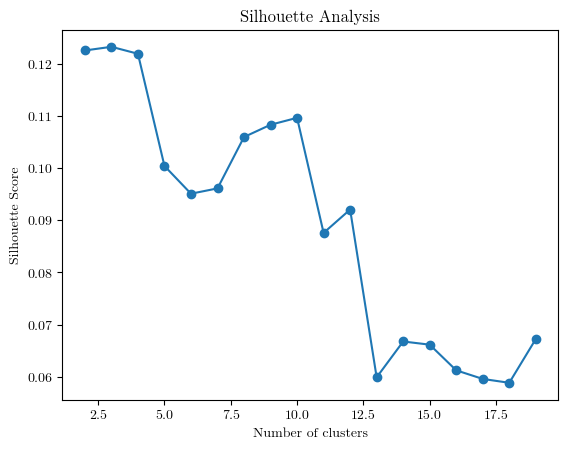

In [8]:
sil_scores = []
K_range = range(2, 20)

for k in K_range:
    model = AgglomerativeClustering(n_clusters=k).fit(features_scaled)
    labels = model.fit_predict(features_scaled)
    sil = silhouette_score(features_scaled, labels)
    sil_scores.append(sil)

plt.plot(K_range, sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


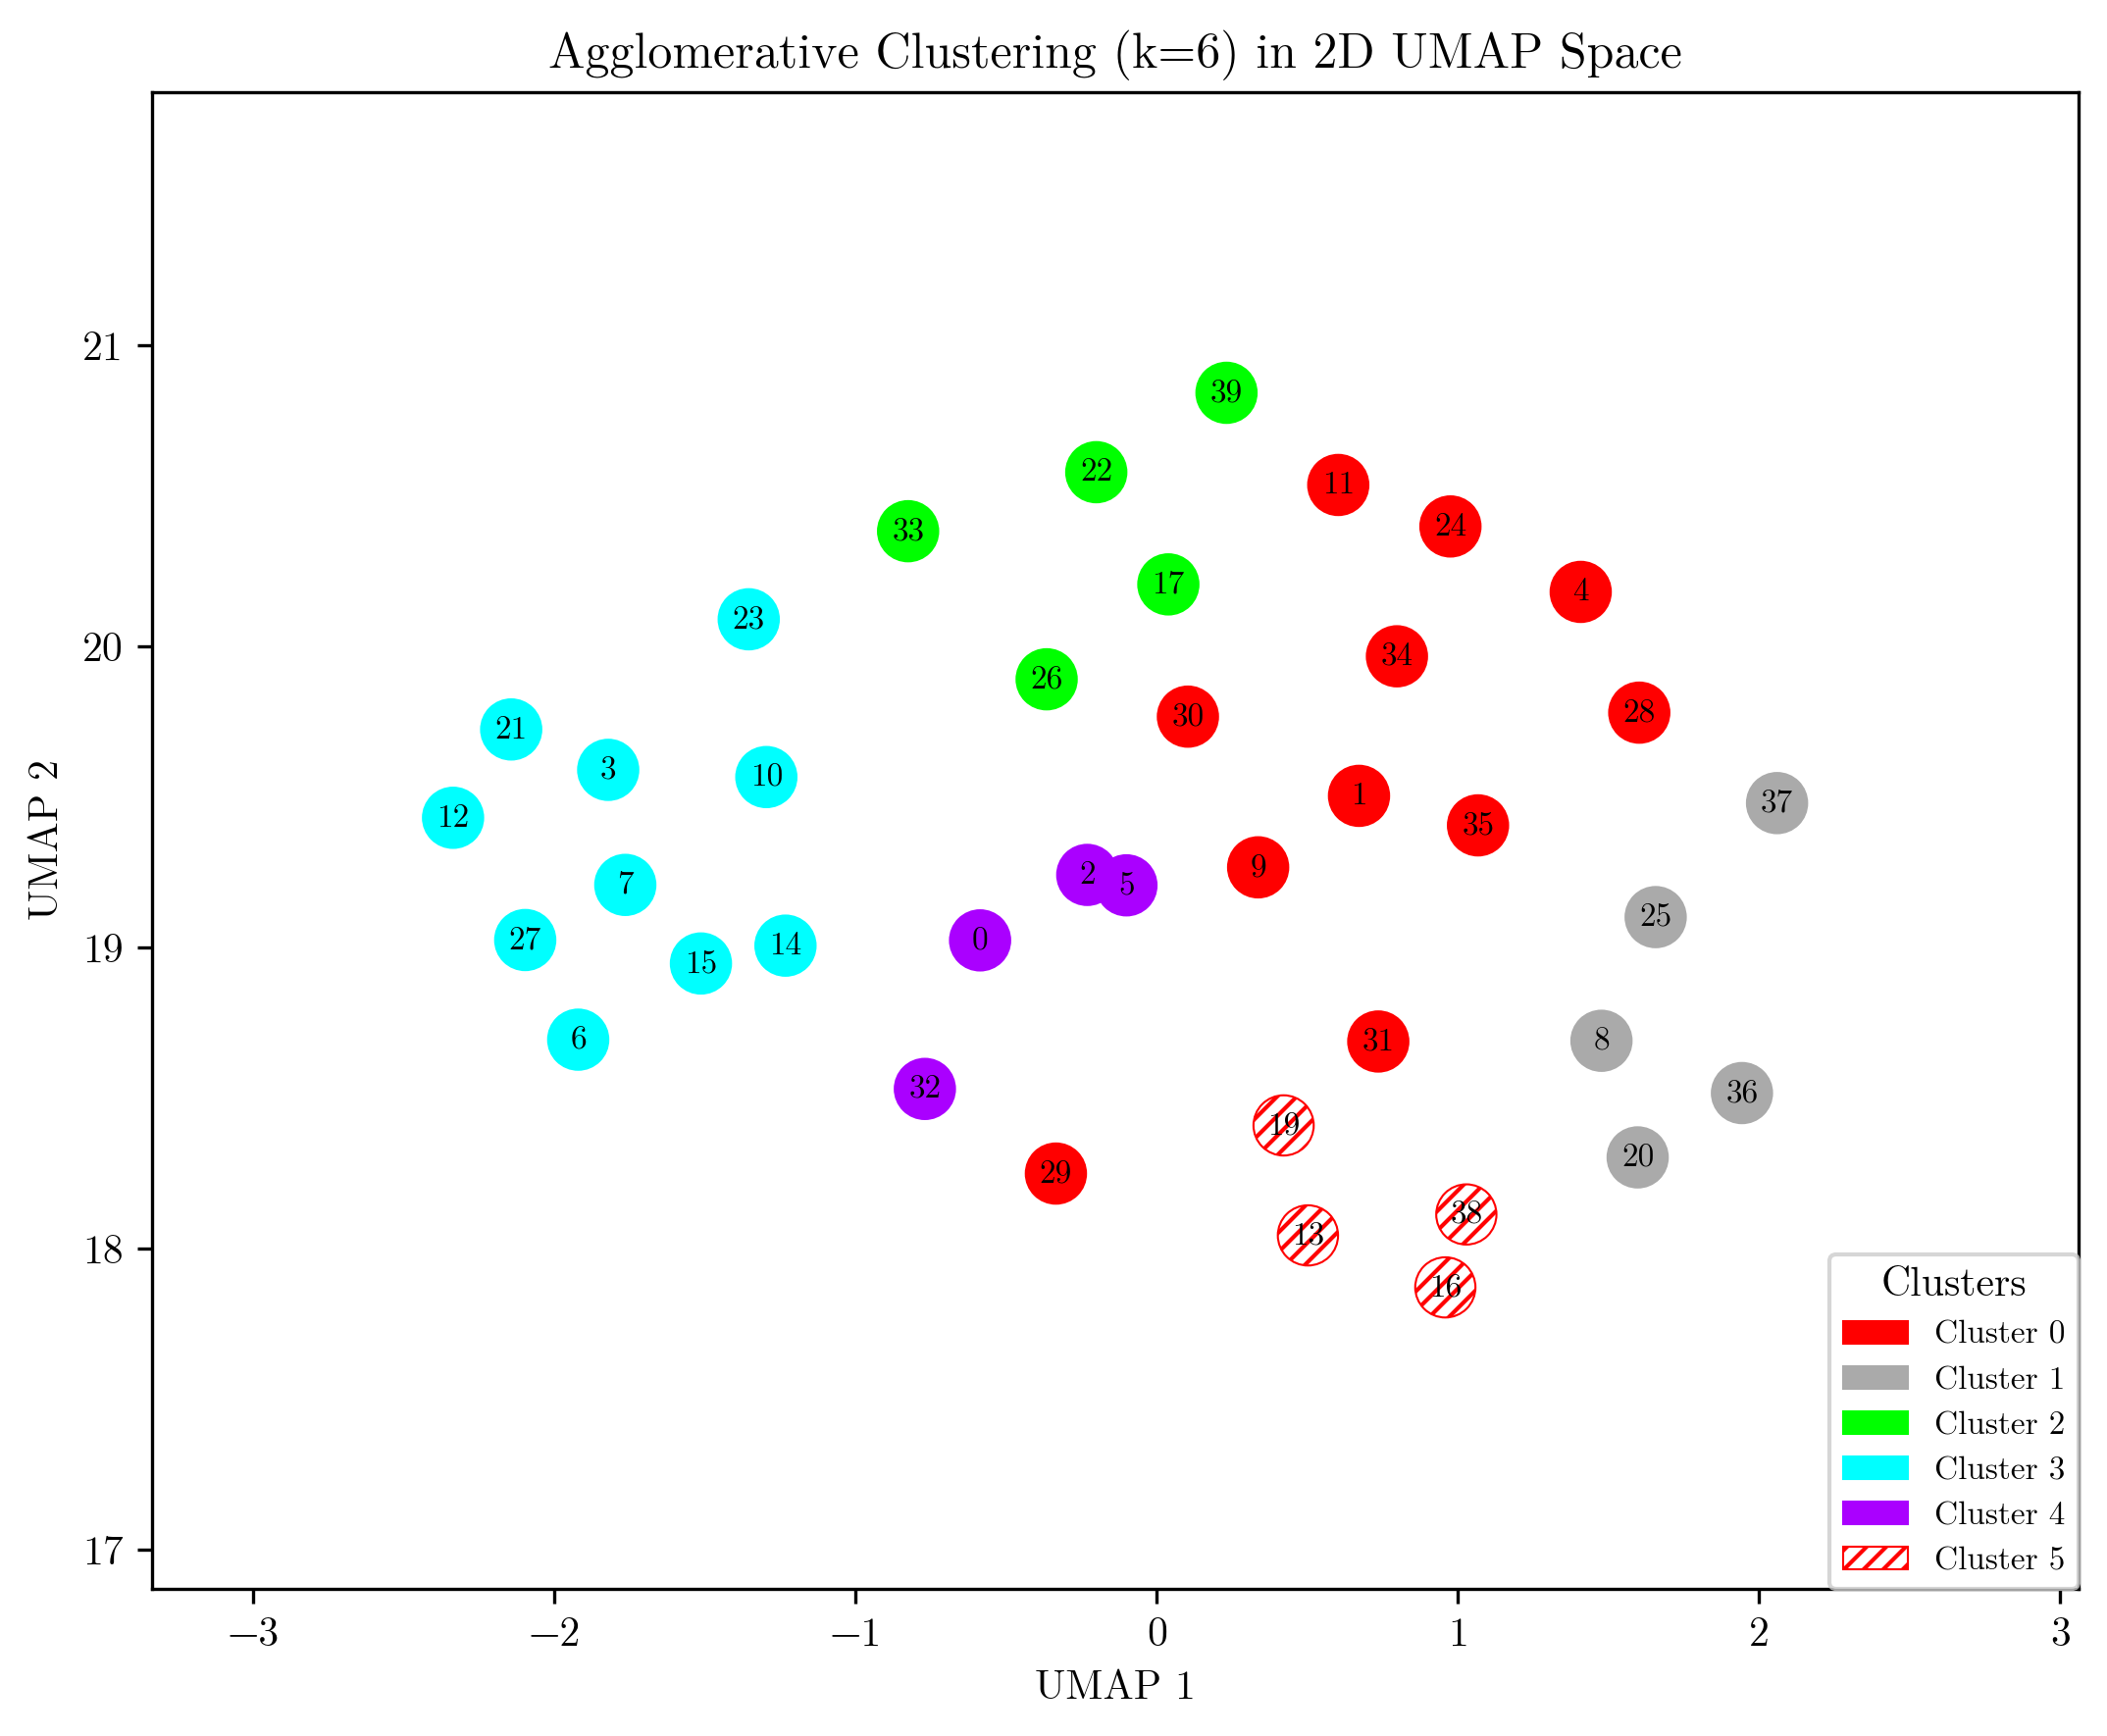

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
import umap
from sklearn.cluster import AgglomerativeClustering
from matplotlib.patches import Patch


# Step 1: Reduce dimensions for clustering
umap_reducer = umap.UMAP(n_components=10, random_state=0)
features_reduced = umap_reducer.fit_transform(features_scaled)

# Step 2: Perform clustering
final_k = 6
model = AgglomerativeClustering(n_clusters=final_k)
labels = model.fit_predict(features_reduced)

# Step 3: UMAP again for 2D visualization
umap_2d = umap.UMAP(n_components=2, random_state=0)
X_2d = umap_2d.fit_transform(features_scaled)

# Base 5-color palette (RYGCB)
base_colors = ['#FF0000', '#AAAAAA', '#00FF00', '#00FFFF', '#AA00FF']
fill_styles = ['solid', 'hatch1', 'hatch2']
hatch_patterns = {'solid': None,
                  'hatch1': '/////',
                  'hatch2': 'xxxx'}

# Define plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Plot each point with pattern + color
for i in range(len(X_2d)):
    label = labels[i]
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]

    x, y = X_2d[i]
    circle = Circle((x, y), radius=0.1,
                    facecolor=color if hatch is None else 'white',
                    edgecolor=color,
                    hatch=hatch,
                    linewidth=.5,
                    alpha=1)
    ax.add_patch(circle)

    video_id = agg_features.index[i]
    ax.text(x, y, str(video_id), fontsize=8, ha='center', va='center', color='black')

# Axis settings
ax.set_title(f'Agglomerative Clustering (k={final_k}) in 2D UMAP Space')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_xlim(X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1)
ax.set_ylim(X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1)
ax.set_aspect('equal')

# Legend setup
legend_elements = []
for label in np.unique(labels):
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]

    legend_elements.append(Patch(
        facecolor=color if hatch is None else 'white',
        edgecolor=color,
        hatch=hatch,
        label=f'Cluster {label}',
        linewidth=0.5
    ))

legend = ax.legend(
    handles=legend_elements,
    title='Clusters',
    # bbox_to_anchor=(1.01, 1),
    fontsize=8,
    loc='lower right',
    borderaxespad=0.,
    handletextpad=0.8
)

# Set all legend text to black for consistency
for text in legend.get_texts():
    text.set_color('black')

plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Start with a DataFrame that includes video numbers and their assigned clusters
video_cluster_df = pd.DataFrame({
    'video_number': agg_features.index,
    'cluster': labels
})

# Stratified split by cluster
train_videos, test_videos = train_test_split(
    video_cluster_df,
    test_size=0.2,
    stratify=video_cluster_df['cluster'],
    random_state=0
)
train_video_ids = train_videos['video_number'].values
test_video_ids = test_videos['video_number'].values

In [11]:
print("Training video IDs:", train_video_ids)
print("Testing video IDs:", test_video_ids)
print("Number of training videos:", len(train_video_ids))
print("Number of testing videos", len(test_video_ids))
print("Train/Test ratio:", 100*len(train_video_ids) / (len(train_video_ids)+len(test_video_ids)), ":", 100*len(test_video_ids) / (len(train_video_ids)+len(test_video_ids)))

Training video IDs: [39 16 19 21 15 12 30 11  4 29 26  0 33 37 23  9 36 13 25  3 20 34 24 31
 17 32  5 10  7 27 35]
Testing video IDs: [ 6  2 22 14 28  1 38  8]
Number of training videos: 31
Number of testing videos 8
Train/Test ratio: 79.48717948717949 : 20.512820512820515


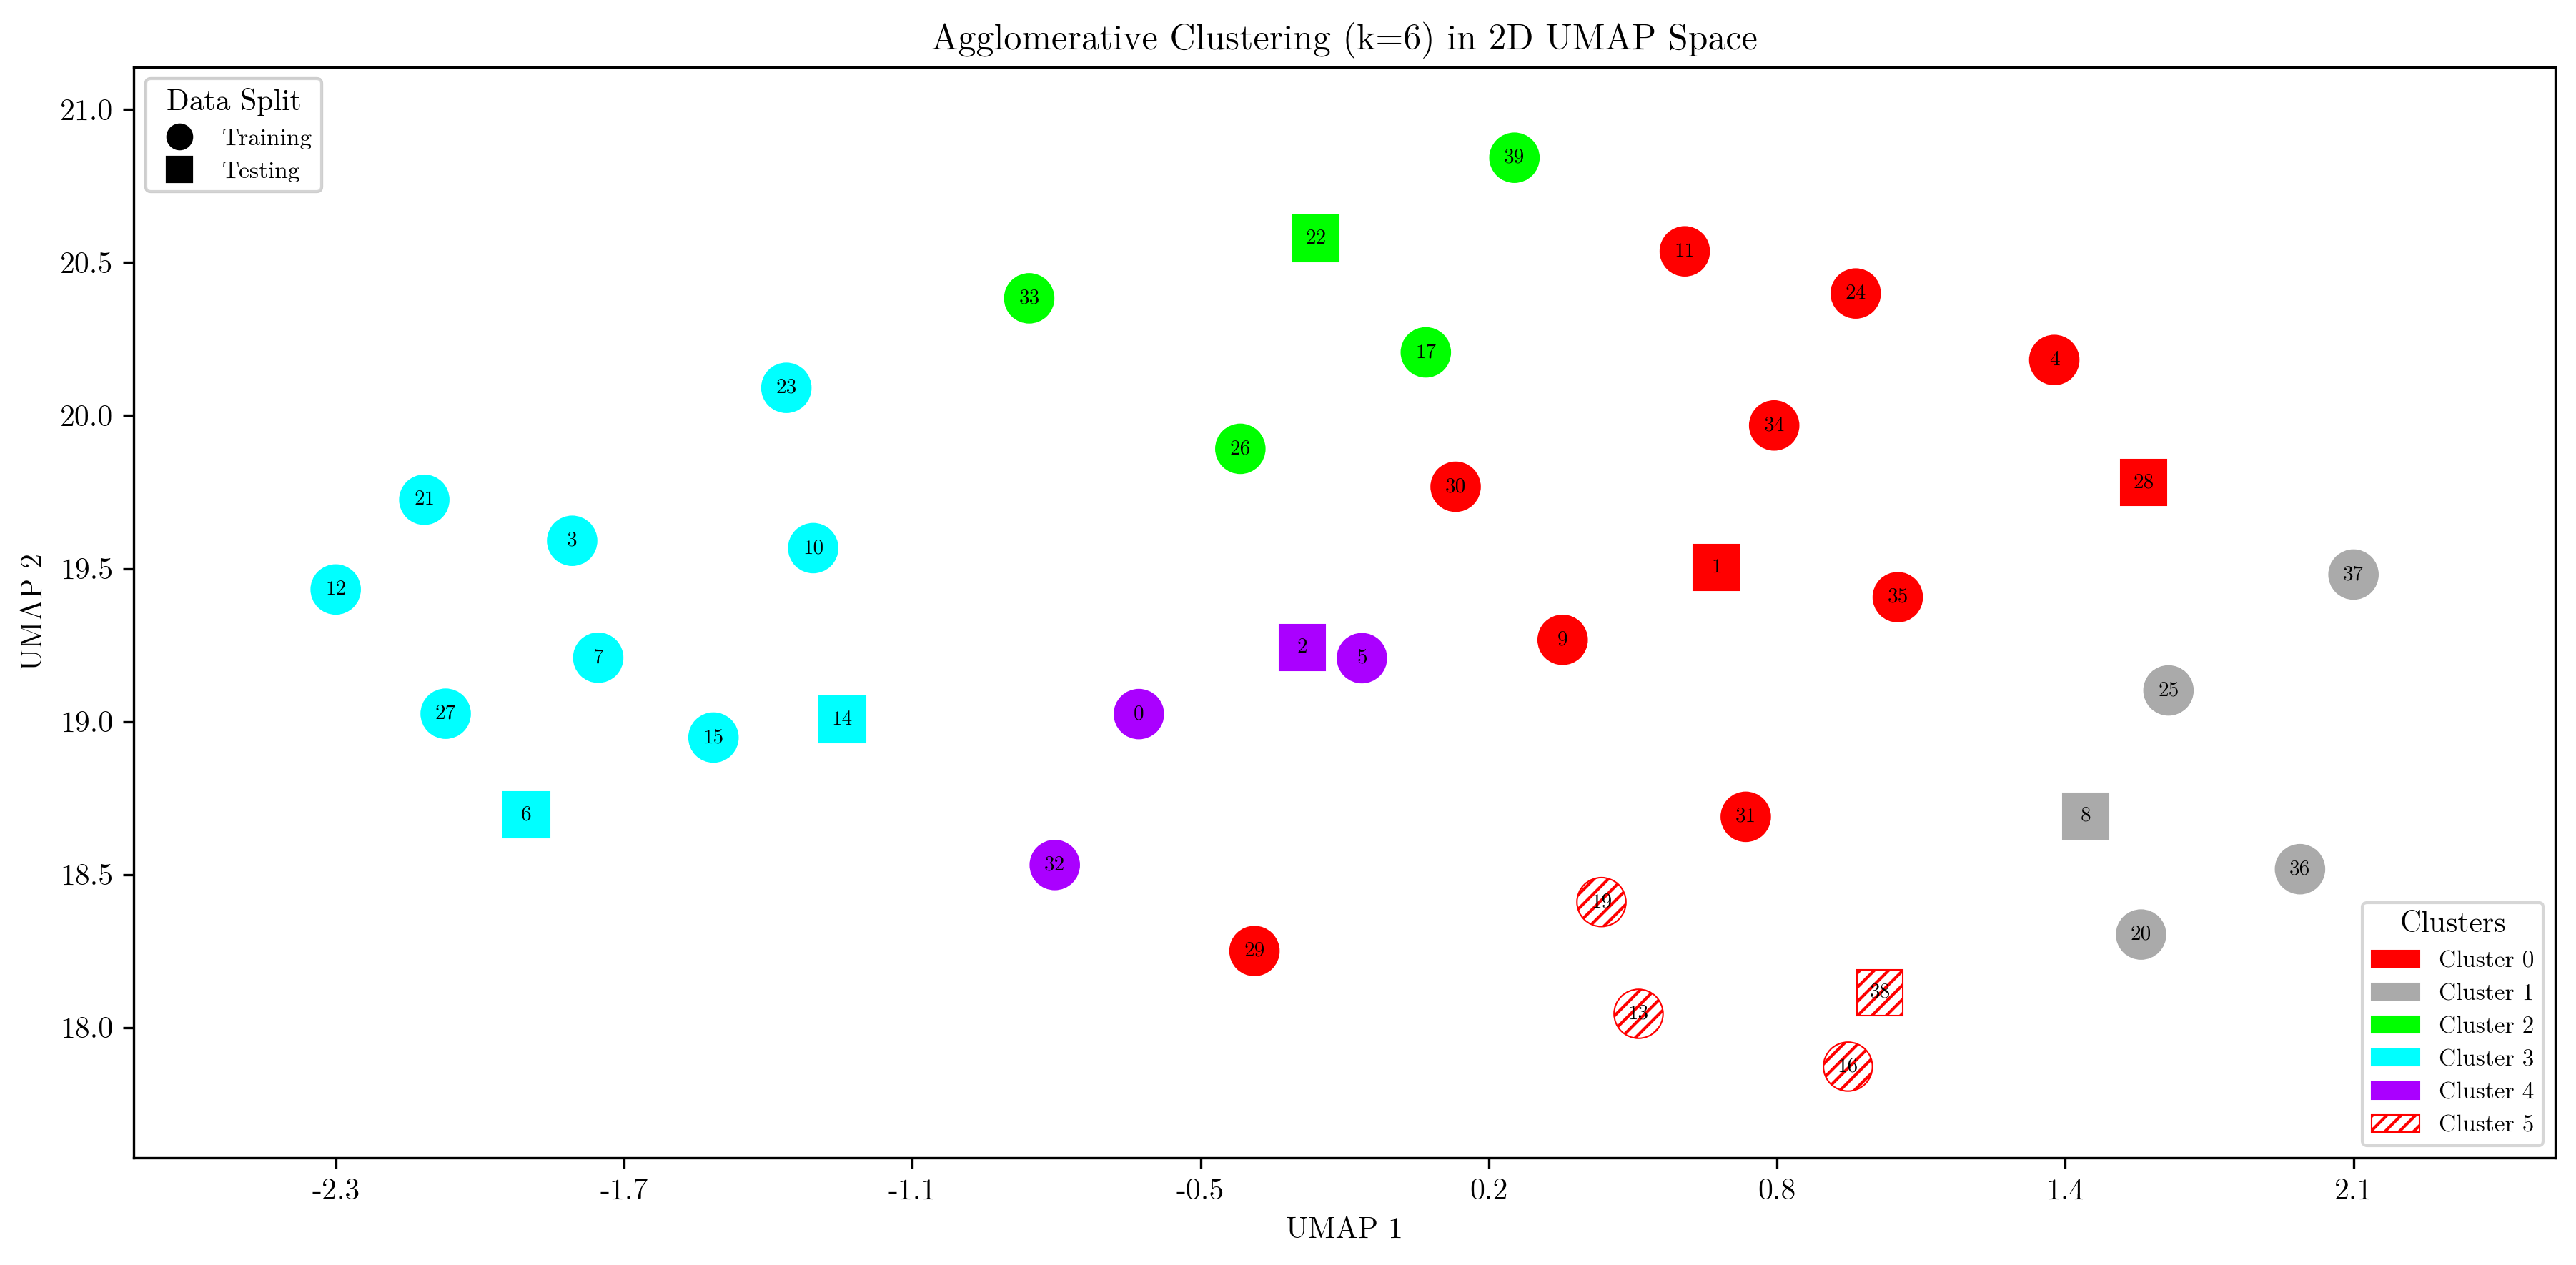

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Patch
from matplotlib.lines import Line2D
import numpy as np
import umap
from sklearn.cluster import AgglomerativeClustering

# UMAP dimensionality reduction
umap_2d = umap.UMAP(n_components=2, random_state=0)
X_2d = umap_2d.fit_transform(features_scaled)

# Stretch factor for X-axis (visual only)
x_stretch_factor = 1.5
X_plot = X_2d.copy()
X_plot[:, 0] *= x_stretch_factor  # Stretch only X values

# Cluster setup
final_k = 6
base_colors = ['#FF0000', '#AAAAAA', '#00FF00', '#00FFFF', '#AA00FF']
fill_styles = ['solid', 'hatch1', 'hatch2']
hatch_patterns = {'solid': None, 'hatch1': '/////', 'hatch2': 'xxxx'}

# Cluster model
model = AgglomerativeClustering(n_clusters=final_k)
labels = model.fit_predict(features_reduced)

# Masks
is_train = agg_features.index.isin(train_video_ids)

# Plot setup
fig, ax = plt.subplots(figsize=(20, 6), dpi=300)

label_offsets = {
}

for i in range(len(X_plot)):
    label = labels[i]
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]
    x, y = X_plot[i]

    if agg_features.index[i] in train_video_ids:
        marker = Circle((x, y), radius=0.08,
                        facecolor=color if hatch is None else 'white',
                        edgecolor=color, hatch=hatch,
                        linewidth=0.5, alpha=1)
    else:
        size = 0.15
        marker = Rectangle((x - size / 2, y - size / 2), width=size, height=size,
                           facecolor=color if hatch is None else 'white',
                           edgecolor=color, hatch=hatch,
                           linewidth=0.5, alpha=1)
    ax.add_patch(marker)

    video_id = agg_features.index[i]
    dx, dy = label_offsets.get(video_id, (0.0, 0.0))
    ax.text(x + dx, y + dy, str(video_id), fontsize=7, ha='center', va='center', color='black')

# Axes labels and title
ax.set_title(f'Agglomerative Clustering (k={final_k}) in 2D UMAP Space')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

# Axis limits (on stretched x-axis)
x_vals = X_plot[:, 0]
y_vals = X_plot[:, 1]
x_margin = (x_vals.max() - x_vals.min()) * 0.1
y_margin = (y_vals.max() - y_vals.min()) * 0.1
ax.set_xlim(x_vals.min() - x_margin, x_vals.max() + x_margin)
ax.set_ylim(y_vals.min() - y_margin, y_vals.max() + y_margin)

# Equal aspect, to keep shapes undistorted
ax.set_aspect('equal', adjustable='box')

# Custom tick labels to show original (unscaled) X values
xticks = np.linspace(x_vals.min(), x_vals.max(), num=8)
xticklabels = [f"{x / x_stretch_factor:.1f}" for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

# --- Legend 1: Cluster Colors & Patterns ---
legend_elements = []
for label in np.unique(labels):
    color = base_colors[label % 5]
    fill_style = fill_styles[label // 5]
    hatch = hatch_patterns[fill_style]
    legend_elements.append(Patch(
        facecolor=color if hatch is None else 'white',
        edgecolor=color,
        hatch=hatch,
        label=f'Cluster {label}',
        linewidth=0.5
    ))

legend1 = ax.legend(
    handles=legend_elements,
    title='Clusters',
    fontsize=8,
    loc='lower right',
    frameon=True
)
ax.add_artist(legend1)

# --- Legend 2: Data Split (Train/Test) ---
marker_handles = [
    Line2D([0], [0], marker='o', color='black', label='Training',
           markersize=8, linestyle='None'),
    Line2D([0], [0], marker='s', color='black', label='Testing',
           markersize=8, linestyle='None')
]
legend2 = ax.legend(
    handles=marker_handles,
    title='Data Split',
    fontsize=8,
    loc='upper left',
    frameon=True
)
ax.add_artist(legend2)

plt.tight_layout()
plt.show()


In [13]:
df_split = video_cluster_df.copy()

# Add 'split' column based on train/test membership
df_split['split'] = df_split['video_number'].apply(
    lambda x: 'train' if x in train_video_ids else 'test'
)
df_split['video_number'] = df_split['video_number'].apply(lambda x: f'{x:03d}_10s')

df_split.to_csv('30s_video_splits.csv', index=False)
